In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pywt
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import BayesianGaussianMixture
from hmmlearn.hmm import GMMHMM
from scipy.stats import anderson_ksamp, norm
import time
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler


plt.rcParams['figure.figsize'] = [15, 5]
plt.style.use('seaborn-deep');

## Data preparation

In [81]:
asks = pd.read_csv('Asks.csv', header=None)
bids = pd.read_csv('Bids.csv', header=None)

col_names = ['time']
lv = 1
for i in range(1, asks.shape[1], 3):
    col_names.append('order'+str(lv))
    col_names.append('price'+str(lv))
    col_names.append('volume'+str(lv))
    lv += 1

asks.columns = col_names
bids.columns = col_names
asks.head(3)

time       order1        price1   volume1       order2  \
0  1.604030e+09  53001558049  13437.000000 -1.000000  53006686518   
1  1.604030e+09  53006737904  13435.043112 -0.041757  53006686518   
2  1.604030e+09  53006737906  13433.766176 -0.010000  53006737904   

         price2   volume2       order3   price3   volume3  ...  volume97  \
0  13437.000000 -0.400040  53006729547  13437.0 -0.022328  ... -4.199900   
1  13436.000000 -0.384894  53006730643  13436.0 -0.106472  ... -0.312879   
2  13433.874034 -0.041757  53006686518  13434.0 -0.384911  ... -1.114421   

       order98  price98  volume98      order99       price99  volume99  \
0  53006740985  13468.0 -1.487708  53001297177  13469.000000   -2.6497   
1  53006727209  13470.0 -0.148757  52955915169  13470.430324   -0.5689   
2  52999487837  13465.0 -2.320000  52999487845  13465.000000   -2.3200   

      order100      price100  volume100  
0  53006634551  13469.000000  -0.312879  
1  52986159744  13470.430324  -1.729846  
2  53005332351  13465.000000  -3.000000  

[3 rows x 301 columns]

In [82]:
for l in range(1, 101):
    asks['volume'+str(l)] = asks['volume'+str(l)] * (-1) #make ask volume positive

## Feature engineering

In [83]:
#Order imbalance
def micro_var(lv, rolling_window, df_bid, df_ask):
    OI = (df_bid['volume'+str(lv)] - df_ask['volume'+str(lv)]) / (df_bid['volume'+str(lv)] + df_ask['volume'+str(lv)]) 
    QS = (df_ask['price'+str(lv)] - df_bid['price'+str(lv)]) * 100 / ((df_ask['price'+str(lv)] + df_bid['price'+str(lv)])/2) 
    ret_sqrt_ask = (np.log(df_ask['price'+str(lv)]) - np.log(df_ask['price'+str(lv)].shift(1)))**2
    ret_sqrt_ask = ret_sqrt_ask.rolling(rolling_window).sum()
    ret_sqrt_bid = (np.log(df_bid['price'+str(lv)]) - np.log(df_bid['price'+str(lv)].shift(1)))**2
    ret_sqrt_bid = ret_sqrt_bid.rolling(rolling_window).sum()
    return  pd.Series(OI), pd.Series(QS), pd.Series(ret_sqrt_ask), pd.Series(ret_sqrt_bid)

In [116]:
def make_df(lv, window, df_bid, df_ask):
    ask_prices = df_ask['price' + str(lv)]
    bid_prices = df_bid['price' + str(lv)]
    ask_prices_grad = pd.Series(np.gradient(ask_prices, 1))
    bid_prices_grad = pd.Series(np.gradient(bid_prices, 1))
    imbalance, spread, ask_volatility, bid_volatility = micro_var(lv, window, df_bid, df_ask)

    df = pd.concat([ask_prices, ask_prices_grad, ask_volatility, bid_prices, bid_prices_grad, bid_volatility, imbalance, spread], axis = 1)
    names = ['ask_price', 'ask_price_grad', 'ask_volat', 'bid_price', 'bid_price_grad', 'bid_volat', 'imbalance', 'spread']
    df.columns = names
    df.dropna(inplace=True)
    df.reset_index(inplace=True)
    df.drop(columns='index', inplace=True)
    return df

def DWT(df, str_):
    (ca, cd) = pywt.dwt(df.loc[:, str_+'_price'], 'sym2', 'smooth')
    sigma_wv = np.median(np.abs(cd)) / 0.6745
    thresh_wv = sigma_wv * np.sqrt(2*np.log(len(df.loc[:, str_+'_price'])))
    cd[np.abs(cd) < thresh_wv] = 0
    ts_recons = pywt.idwt(ca, cd, 'sym2', 'smooth')
    return ts_recons

def make_small_df(df):
    df.reset_index(inplace=True)
    df.drop(columns='index', inplace=True)
    df.loc[:,'ask_dwt'] = pd.Series(DWT(df, 'ask'), dtype='float64')
    df.loc[:,'bid_dwt'] = pd.Series(DWT(df, 'bid'), dtype='float64')
    df.loc[:,'ask_dwt_grad'] = pd.Series(np.gradient(df.loc[:, 'ask_dwt'], 1))
    df.loc[:,'bid_dwt_grad'] = pd.Series(np.gradient(df.loc[:, 'bid_dwt'], 1))
    for c in df.columns: 
        scaler = MinMaxScaler()
        df.loc[:, c] = scaler.fit_transform(np.array(df.loc[:, c]).reshape(-1, 1))
    return df

In [195]:
window_size = 12 #minute
lv1_df = make_df(1, window_size, bids, asks)
lv2_df = make_df(2, window_size, bids, asks)
lv3_df = make_df(3, window_size, bids, asks)
lv4_df = make_df(4, window_size, bids, asks)
lv5_df = make_df(5, window_size, bids, asks)
lv6_df = make_df(6, window_size, bids, asks)
lv7_df = make_df(7, window_size, bids, asks)
lv8_df = make_df(8, window_size, bids, asks)
lv9_df = make_df(9, window_size, bids, asks)
lv10_df = make_df(10, window_size, bids, asks)

In [197]:
train_size = 731*4
lv1_df_train = lv1_df.iloc[:train_size, :] #training set
lv1_df_train = make_small_df(lv1_df_train)
lv1_df_train.head()

C:\Users\anas1\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4305: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\anas1\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\anas1\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

ask_price  ask_price_grad  ask_volat  bid_price  bid_price_grad  bid_volat  \
0   0.843085        0.706305   0.023036   0.844998        0.745702   0.022905   
1   0.864362        0.706305   0.080142   0.864827        0.755758   0.073674   
2   0.864362        0.553581   0.078592   0.866763        0.611956   0.070413   
3   0.864362        0.610852   0.078592   0.866763        0.643014   0.070413   
4   0.872340        0.610852   0.087127   0.872982        0.643014   0.075538   

   imbalance    spread   ask_dwt   bid_dwt  ask_dwt_grad  bid_dwt_grad  
0   0.295446  0.032898  0.840487  0.843439      0.859293      0.877508  
1   0.285713  0.097075  0.861944  0.863527      0.691329      0.727223  
2   0.856322  0.011235  0.859398  0.862302      0.568370      0.617207  
3   0.042939  0.011235  0.863284  0.866789      0.614224      0.644985  
4   0.857143  0.089262  0.867290  0.869504      0.614845      0.635841

## Model training

In [25]:
dict_of_components = dict()
for col in lv1_df_train.columns:
    X = np.array(lv1_df_train[col]).reshape(-1, 1)
    GMM_comp = BayesianGaussianMixture(n_components=10, random_state=1,  max_iter = 10000)
    GMM_comp.fit(X)
    n_component = GMM_comp.weights_[GMM_comp.weights_>0.05].shape[0]
    dict_of_components[col] = n_component

components_df = pd.DataFrame(dict_of_components.values())
components_df=components_df.transpose()
components_df.columns = dict_of_components.keys()
print('Median number of components is {}'.format(int(components_df.iloc[0,:].median())))
components_df

Median number of components is 5


ask_price  ask_price_grad  ask_volat  bid_price  bid_price_grad  bid_volat  \
0          5               6          4          6               5          4   

   imbalance  spread  ask_dwt  bid_dwt  ask_dwt_grad  bid_dwt_grad  
0          7       4        5        6             5             6

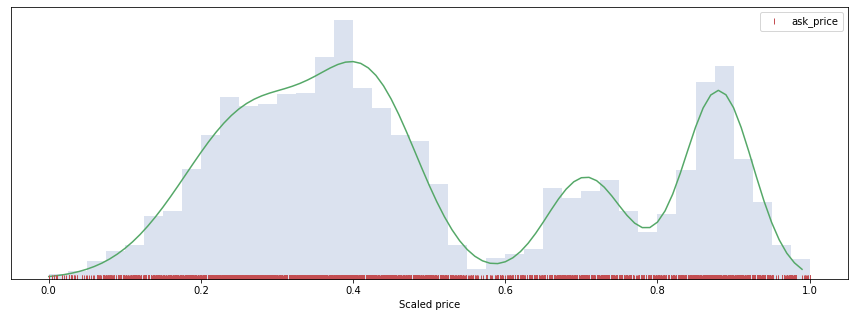

In [26]:
сol_name = 'ask_price'
def mix_pdf(x, loc, scale, weights):
    d = np.zeros_like(x)
    for mu, sigma, pi in zip(loc, scale, weights):
        d += pi * norm.pdf(x, loc=mu, scale=sigma)
    return d

mix = BayesianGaussianMixture(n_components=5, random_state=1, max_iter=10000).fit(np.array(lv1_df_train[сol_name]).reshape(-1, 1))
pi, mu, sigma = mix.weights_.flatten(), mix.means_.flatten(), np.sqrt(mix.covariances_.flatten())

grid = np.arange(np.min(lv1_df_train[сol_name]), np.max(lv1_df_train[сol_name]), 0.01)

plt.hist(lv1_df_train[сol_name], bins=40, density=True, alpha=0.2)
plt.plot(grid, mix_pdf(grid, mu, sigma, pi))
plt.plot(lv1_df_train[сol_name], [0.01]*lv1_df_train[сol_name].shape[0], '|', label = сol_name)
plt.legend(loc='upper right')
plt.xlabel('Scaled price')
plt.yticks([])
plt.show()

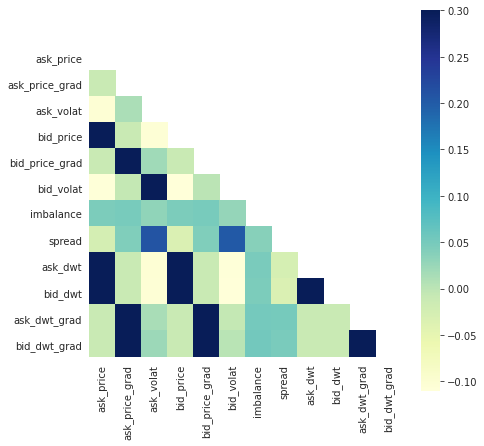

In [32]:
corr = lv1_df_train.corr() #low correlation among features
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 7))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, cmap="YlGnBu")

We can use diagonal covariances because features are not higher correlated. We use median value of 9 components in Gaussian Mixture Model. We use 9 states because assume that each component generates 9 states and there are at most 9 classes produced by OPTICS clustering.

In [33]:
def BIC_AIC(df, model, n_states, n_mix):
    n = df.shape[0]
    MLL = model.score(df.values)
    means_weights = 2*n_mix*n_states#means, weights
    trans_pobs = n_states**2
    pi = n_states
    covar = n_mix*n_states*df.shape[1]
    n_params = covar+pi+trans_pobs+means_weights
    BIC_score = n_params*np.log(n)-2*np.log(MLL)
    AIC_score = 2*n_params-2*np.log(MLL)
    print("BIC for the model with " +str(n_states)+" states is "+str(round(BIC_score, 4)))
    print("AIC for the model with " +str(n_states)+" states is "+str(round(AIC_score, 4)))

In [34]:
for state_num in range(1, 20):
    HMM = GMMHMM(n_components=state_num, n_mix = 6, algorithm = 'viterbi', random_state = 1, covariance_type = 'diag').fit(lv1_df_train.values)
    BIC_AIC(lv1_df_train, HMM, state_num, 7)

BIC for the model with 1 states is 844.4952
AIC for the model with 1 states is 177.1097
BIC for the model with 2 states is 1728.9646
AIC for the model with 2 states is 380.8459
BIC for the model with 3 states is 2630.8567
AIC for the model with 3 states is 588.6571
BIC for the model with 4 states is 3550.2208
AIC for the model with 4 states is 800.5925


KeyboardInterrupt: 

In [198]:
HMM = GMMHMM(n_components=5, n_mix = 5, algorithm = 'viterbi', random_state = 1, covariance_type = 'diag').fit(lv1_df_train.values)

We are looking for outliers, so are more interested in the tails of distribution that its center, hence use Anderson Darling test, not Kolmogorov Smirnov. It can be used for different sample sizes.

https://www.itl.nist.gov/div898/handbook/eda/section3/eda35e.htm

https://stats.stackexchange.com/questions/201434/2-sample-kolmogorov-smirnov-vs-anderson-darling-vs-cramer-von-mises#:~:text=Anderson-Darling%20test%20is%20much,get%20much%20more%20powerful%20test.

In [199]:
print(time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime(time.time())))
states = np.full((lv1_df.shape[0], 12), -1, dtype ='float64')
breaks=list()
end = 731
sliding_window = 12 # 12 in a minute
h = 0
for i in range(17000):
    if lv1_df.shape[0] - end >= sliding_window:
        dataset = lv1_df.iloc[h:end, :].copy()
        dataset = make_small_df(dataset)
        if end > train_size:
            temp_df = make_small_df(lv1_df.iloc[end-train_size:end, :])
            for cc in lv1_df.columns:
                ADtest = anderson_ksamp([np.array(temp_df.loc[:, cc]), np.array(lv1_df_train.loc[:, cc])])#
                if ADtest[0] > ADtest[1][2]: #test at 5% significance 4
                    HMM = GMMHMM(n_components=5, n_mix = 5, algorithm = 'viterbi', random_state = 1, covariance_type = 'diag').fit(temp_df.values)    
                    lv1_df_train = temp_df.copy()
                    breaks.append(end)
                    break
        for pos, c in enumerate(dataset.columns):
            probs, st = HMM.decode(np.array(dataset.loc[:, c]).reshape(-1, 1), algorithm='viterbi')
            if h == 0:
                states[:end, pos] = st
            else:
                states[end-sliding_window:end, pos] = st[-sliding_window:]

        end += sliding_window
        h += sliding_window
    else:
        dataset = lv1_df.iloc[h:, :].copy()
        dataset = make_small_df(dataset)
        temp_df = make_small_df(lv1_df.iloc[end-train_size:end, :])
        for cc in dataset.columns:
                ADtest = anderson_ksamp([np.array(temp_df.loc[:, cc]),np.array(lv1_df_train.loc[:, cc])])
                if ADtest[0] > ADtest[1][2]: #test at 5% significance
                    HMM = GMMHMM(n_components=5, n_mix = 5, algorithm = 'viterbi', random_state = 1, covariance_type = 'diag').fit(temp_df.values)
                    breaks.append(end)
                    break
        for pos, c in enumerate(dataset.columns):
            probs, st = HMM.decode(np.array(dataset.loc[:, c]).reshape(-1, 1), algorithm='viterbi')
            states[-(lv1_df.shape[0] - end):, pos] = st[-(lv1_df.shape[0] - end):]
        break

print(time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime(time.time())))

er,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\anas1\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\anas1\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-199-5afd60eda6f3>:14: UserWa

In [200]:
states_df = pd.DataFrame(states, columns=lv1_df_train.columns)
states_df.head()

ask_price  ask_price_grad  ask_volat  bid_price  bid_price_grad  bid_volat  \
0        2.0             4.0        2.0        2.0             4.0        2.0   
1        1.0             4.0        1.0        1.0             4.0        1.0   
2        1.0             1.0        1.0        1.0             1.0        1.0   
3        1.0             1.0        1.0        1.0             1.0        1.0   
4        4.0             1.0        1.0        4.0             1.0        1.0   

   imbalance  spread  ask_dwt  bid_dwt  ask_dwt_grad  bid_dwt_grad  
0        2.0     2.0      2.0      2.0           4.0           4.0  
1        1.0     1.0      1.0      1.0           4.0           4.0  
2        4.0     1.0      1.0      1.0           1.0           1.0  
3        1.0     1.0      1.0      1.0           1.0           1.0  
4        4.0     1.0      4.0      4.0           1.0           1.0

In [41]:
#states_df = pd.read_csv('lv1_labels_model_1.csv')
#states_df.drop(columns = 'Unnamed: 0', inplace = True)
#states_df.groupby('spread').mean()

In [59]:
def plot_class_graph(col_name, units, df_labs, df_data):
    fig = go.Figure()
    available_classes = np.sort(df_labs[col_name].unique())
    for cl in available_classes:
        sm_df = np.full(df_labs.shape[0], None)
        ind = np.array(df_labs[df_labs[col_name]==cl].index)
        sm_df[ind] = df_data[col_name][ind]
        sm_df = pd.DataFrame(sm_df)
        fig.add_trace(go.Scatter(x=sm_df.index, y=sm_df.iloc[:, 0], name='state '+str(int(cl))))

    fig.update_layout(
        title=col_name,
        xaxis_title="Observation",
        yaxis_title=units,
        width=800,
        height=500)
    fig.update_xaxes(rangeslider_visible=True)
    fig.show()

In [126]:
plot_class_graph('ask_price', 'Dollars', states_df, lv1_df)

In [204]:
for stat_num, stat_col in enumerate(states_df.columns):
    if stat_num == 0:
        stat_count=states_df.loc[:, stat_col].value_counts().sort_index().copy()
    else:
        stat_count += states_df.loc[:, stat_col].value_counts().sort_index()
stat_count = stat_count[0:]
stat_thresh = stat_count.sum()*0.2
anomalous_states = stat_count[stat_count<stat_thresh].index.to_list()
anomalous_states

[2.0, 3.0]

In [222]:
lv1_df['trade_type']=0
for row in range(lv1_df.shape[0]):
    if (((states_df.at[row, 'ask_price'] in anomalous_states)|(states_df.at[row, 'ask_dwt'] in anomalous_states)) & ((states_df.at[row, 'bid_price'] in anomalous_states)|(states_df.at[row, 'bid_dwt'] in anomalous_states)))&(
 (states_df.at[row, 'ask_volat'] not in anomalous_states) & (states_df.at[row, 'bid_volat'] not in anomalous_states)&(states_df.at[row, 'imbalance'] not in anomalous_states)&(states_df.at[row, 'spread'] not in anomalous_states)&(states_df.at[row, 'ask_price_grad'] not in anomalous_states)&(states_df.at[row, 'bid_price_grad'] not in anomalous_states)&(states_df.at[row, 'ask_dwt_grad'] not in anomalous_states)&(states_df.at[row, 'bid_dwt_grad'] not in anomalous_states)):
        lv1_df.at[row, 'trade_type'] = 1

    elif (((states_df.at[row, 'ask_price_grad'] in anomalous_states)|(states_df.at[row, 'ask_dwt_grad'] in anomalous_states)) & ((states_df.at[row, 'bid_price_grad'] in anomalous_states)|(states_df.at[row, 'bid_dwt_grad'] in anomalous_states)))&((states_df.at[row, 'ask_volat'] not in anomalous_states) & (states_df.at[row, 'bid_volat'] not in anomalous_states)&(states_df.at[row, 'imbalance'] not in anomalous_states)&(states_df.at[row, 'spread'] not in anomalous_states)&(states_df.at[row, 'ask_price'] not in anomalous_states)&(states_df.at[row, 'bid_price'] not in anomalous_states)&(states_df.at[row, 'ask_dwt'] not in anomalous_states)&(states_df.at[row, 'bid_dwt'] not in anomalous_states)):
        lv1_df.at[row, 'trade_type'] = 2

    elif (states_df.at[row, 'ask_price_grad'] in anomalous_states)&(states_df.at[row, 'ask_dwt_grad'] in anomalous_states)&(states_df.at[row, 'bid_price_grad'] in anomalous_states)&(states_df.at[row, 'bid_dwt_grad'] in anomalous_states)&(states_df.at[row, 'ask_price']  in anomalous_states)&(states_df.at[row, 'bid_price']  in anomalous_states)&(states_df.at[row, 'ask_dwt']  in anomalous_states)&(states_df.at[row, 'bid_dwt']  in anomalous_states)&(states_df.at[row, 'bid_volat']  in anomalous_states)&(states_df.at[row, 'ask_volat']  in anomalous_states)&(states_df.at[row, 'imbalance']  in anomalous_states)&(states_df.at[row, 'spread']  in anomalous_states):
        lv1_df.at[row, 'trade_type'] = 3
#&(states_df.at[row, 'bid_volat']  in anomalous_states)&(states_df.at[row, 'ask_volat']  in anomalous_states)&(states_df.at[row, 'imbalance']  in anomalous_states)&(states_df.at[row, 'spread']  in anomalous_states)

Why differet patterns? Because at first we train at 10k+ observations, but at later re-trainings we keep only last 12 observations. Thus, the patterns change rapidly after first training.

In [223]:
lv1_df[lv1_df['trade_type']==3]

ask_price  ask_price_grad     ask_volat     bid_price  \
3300   13284.408389       -0.500000  2.362940e-07  13284.000000   
3301   13284.000000       -0.204194  2.325625e-07  13283.880114   
3328   13258.000000        0.000000  1.849271e-07  13257.962387   
3329   13258.000000        3.000000  1.849271e-07  13257.962387   
3330   13264.000000        6.441559  3.896422e-07  13263.767351   
...             ...             ...           ...           ...   
16792  13495.000000       -3.000000  3.320193e-07  13494.000000   
16793  13493.000000       -3.500000  3.485075e-07  13492.178416   
16794  13488.000000       -3.330166  4.639531e-07  13486.000000   
16796  13486.339668       -9.169834  4.791078e-07  13486.000000   
16798  13450.000000       -9.500000  4.101743e-06  13437.000000   

       bid_price_grad     bid_volat  imbalance    spread  trade_type  
3300        -0.125373  2.487883e-07  -0.036726  0.003074           3  
3301        -0.413795  2.393298e-07  -0.795438  0.000902           3  
3328         0.481193  2.491734e-07  -0.921699  0.000284           3  
3329         2.902482  2.491678e-07  -0.915377  0.000284           3  
3330         5.518807  4.393591e-07  -0.959198  0.001754           3  
...               ...           ...        ...       ...         ...  
16792       -2.919374  3.850129e-07  -0.203312  0.007410           3  
16793       -4.000000  4.017167e-07  -0.387590  0.006089           3  
16794       -3.089208  5.895836e-07  -0.197413  0.014829           3  
16796      -14.000000  5.895836e-07   0.208794  0.002519           3  
16798       -5.000000  7.342472e-06  -0.864814  0.096701           3  

[1503 rows x 9 columns]

In [224]:
lv1_df.groupby('trade_type').median()

ask_price  ask_price_grad     ask_volat     bid_price  \
trade_type                                                             
0           13491.000000             0.0  3.137508e-07  13490.000000   
1           13327.575842             0.0  2.750413e-07  13327.075842   
2           13540.000000             0.0  2.979357e-07  13539.118599   
3           13538.719610             0.0  1.862355e-07  13537.703716   

            bid_price_grad     bid_volat  imbalance    spread  
trade_type                                                     
0                      0.0  3.055734e-07  -0.112013  0.006777  
1                      0.0  2.608063e-07  -0.688124  0.005958  
2                      0.0  3.150523e-07  -0.578682  0.006382  
3                      0.0  1.740875e-07  -0.505065  0.006927

In [227]:
def plot_trade_type(col_name, units, df_data):
    fig = go.Figure()
    available_classes = np.sort(df_data['trade_type'].unique())
    for cl in available_classes:
        sm_df = np.full(df_data.shape[0], None)
        ind = np.array(df_data[df_data['trade_type']==cl].index)
        sm_df[ind] = df_data[col_name][ind]
        sm_df = pd.DataFrame(sm_df)
        fig.add_trace(go.Scatter(x=sm_df.index, y=sm_df.iloc[:, 0], name='type '+str(int(cl))))

    fig.update_layout(
        title=col_name,
        xaxis_title="Observation",
        yaxis_title=units,
        width=800,
        height=500)
    fig.update_xaxes(rangeslider_visible=True)
    fig.show()

In [228]:
plot_trade_type('ask_price', 'Dollars', lv1_df)